# Some imports and helper code

In [502]:
import numpy as np
import networkx as nx
from spectrum_attack import spectrum_attack
import matplotlib.pylab as plt
from threat_model import Threat_Model

np.random.seed(1)

In [2]:
def plot_results(results, alphas):
    plt.figure()
    results[['lambda', 'lambda_sub', 'centrality']].plot(kind='line')
    plt.xlabel('iterations')
    title_template = r'$\alpha_1={:.2f}, \alpha_2={:.2f}, \alpha_3={:.2f}$'
    plt.title(title_template.format(*alphas))
    
    
def plot_adj_matrices(graph, final_adj):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(nx.to_numpy_array(graph))
    axes[0].set_title('before attack')
    axes[1].imshow(final_adj.A)
    axes[1].set_title('after attack')

# Run the attack on a BA network (old nodes)

In this experiment, I'll use a subgraph made of three nodes that are 'old' in the BA growth process, i.e., nodes of large degree.

In [6]:
graph = nx.barabasi_albert_graph(100, 2)
subgraph = [1, 2, 3]
alphas = [0.5, 0.3, 0.2]
results, final_adj = spectrum_attack(graph, subgraph, alphas, verbose=True)

(0) utility: 2.372, lambda_1: 6.982, lambda_1_S: 2.000
(10) utility: 2.686, lambda_1: 7.297, lambda_1_S: 2.523
(20) utility: 2.975, lambda_1: 7.645, lambda_1_S: 3.023
(30) utility: 3.246, lambda_1: 8.016, lambda_1_S: 3.504
(40) utility: 3.503, lambda_1: 8.405, lambda_1_S: 3.969
(50) utility: 3.750, lambda_1: 8.805, lambda_1_S: 4.420
(60) utility: 3.989, lambda_1: 9.216, lambda_1_S: 4.860
(70) utility: 4.221, lambda_1: 9.633, lambda_1_S: 5.291
(80) utility: 4.448, lambda_1: 10.055, lambda_1_S: 5.713
(90) utility: 4.671, lambda_1: 10.481, lambda_1_S: 6.129


## Plot the behavior of $\lambda_1$ and $\lambda_1^S$

<Figure size 432x288 with 0 Axes>

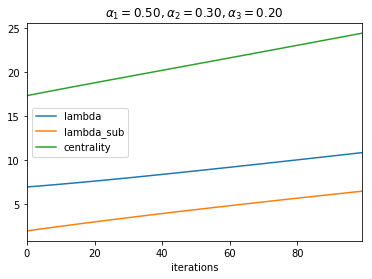

In [7]:
plot_results(results, alphas)

## Plot the original and final adjacency matrices

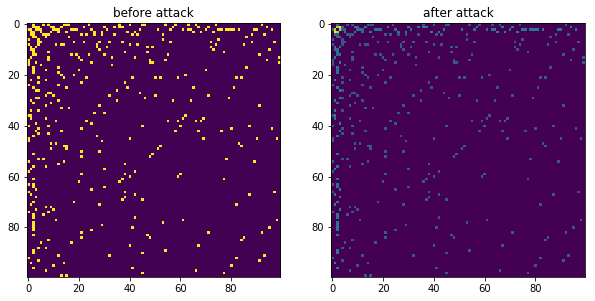

In [8]:
plot_adj_matrices(graph, final_adj)

Note that the weights of most edges has decreased, while the edges incident to (and between) nodes in the subgraph have increased weights (see top left corner of the matrix after attack).

# Run attack on a BA network (new nodes)

In this experiment, I'll use a subgraph induced by the egonet of a random node. Since the node is random, it is likely to have low degree.

In [149]:
import operator
maxDegNode = max(dict(graph.degree).items(), key=operator.itemgetter(1))[0]

graph = nx.barabasi_albert_graph(100, 2)
# center = np.random.choice(range(graph.order()))
# subgraph = list(graph.neighbors(center)) + [center] 
center = maxDegNode
subgraph = list(graph.neighbors(maxDegNode))

alphas = [0.5, 0.3, 0.2]
results, final_adj = spectrum_attack(graph, subgraph, alphas, verbose=True)

(0) utility: 0.054, lambda_1: 7.686, lambda_1_S: 2.000
(10) utility: -0.016, lambda_1: 7.492, lambda_1_S: 1.736
(20) utility: 0.042, lambda_1: 7.369, lambda_1_S: 1.772
(30) utility: 0.141, lambda_1: 7.274, lambda_1_S: 1.907
(40) utility: 0.194, lambda_1: 7.164, lambda_1_S: 1.941
(50) utility: 0.244, lambda_1: 7.060, lambda_1_S: 1.976
(60) utility: 0.293, lambda_1: 6.962, lambda_1_S: 2.011
(70) utility: 0.424, lambda_1: 6.916, lambda_1_S: 2.241
(80) utility: 0.465, lambda_1: 6.828, lambda_1_S: 2.269
(90) utility: 0.376, lambda_1: 6.676, lambda_1_S: 1.998


In [150]:
print(subgraph)
print(maxDegNode)

[1, 2, 8, 13, 15, 26, 47, 57, 67, 86]
4


## Plot behavior of $\lambda_1$ and $\lambda_1^S$

<Figure size 432x288 with 0 Axes>

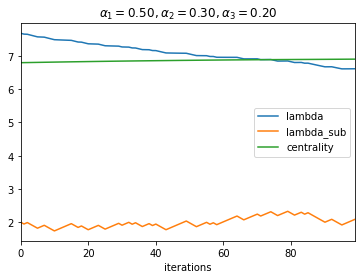

In [151]:
plot_results(results, alphas)

Different than before, now $\lambda_1$ is decreasing, and $\lambda_1^S$ is oscillating.

## Plot adjacency matrices

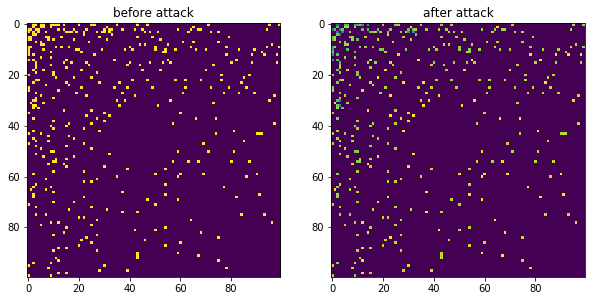

In [124]:
plot_adj_matrices(graph, final_adj)

As before, the weights of most edges have decreased, while the edges incident to (and between) nodes in the subgraph have increased weights. Interestingly, the weights of edges incident to the nodes of largest degree seem to have decreased the most. (I.e. if you look at the top left corner of the right matrix, the colors are darker.)

# Threat model with Tina's objective function